# Agregate data

The purpuse of this code is to aggregate all the database that we have extract to get a usefull database for apply all the model that we want

In [211]:
import numpy as np
import pandas as pd
import missingno as msno
from scipy.interpolate import griddata

import os
os.chdir("F:/Defi_IA/data")

In [212]:
features_forecast = ['ws', 'p3031', 'u10', 'v10', 't2m', 'd2m', 'r', 'tp', 'msl']
features_observed = ['ff', 't', 'td', 'hu', 'dd', 'precip']

# Y values
predictions_inter = pd.read_csv('Dataset/predictions_interpolate.csv')
#predictions = pd.read_csv('Dataset/predictions_time_interpolate.csv')
predictions_no_inter = pd.read_csv('Dataset/predictions.csv')

predictions_inter.sort_values(['station', 'test', 'day_index'], inplace=True)
predictions_no_inter.sort_values(['station', 'test', 'day_index'], inplace=True)

predictions = pd.concat([predictions_no_inter[~predictions_no_inter.test], predictions_inter[predictions_inter.test]])
#predictions = predictions_inter

# Feature mesured and interpolated
df_features_observed_inter = pd.read_csv('Dataset/features_interpolate.csv')
#df_features_observed = pd.read_csv('Dataset/features_time_interpolate.csv')
df_features_observed_no_inter = pd.read_csv('Dataset/features.csv')

df_features_observed_inter.sort_values(['station', 'test', 'day_index', 'hour'], inplace=True)
df_features_observed_no_inter.sort_values(['station', 'test', 'day_index', 'hour'], inplace=True)

df_features_observed = pd.concat([df_features_observed_no_inter[~df_features_observed_no_inter.test], df_features_observed_inter[df_features_observed_inter.test]])
#df_features_observed = df_features_observed_inter

# Feature from forecast model(ARPEGE)
df_features_forecast = pd.read_csv('Dataset/features_forecast_final.csv')[['station', 'test', 'day_index', 'hour'] + features_forecast]
print(df_features_observed.shape)
print(df_features_forecast.shape)

(8525400, 12)
(8525400, 13)


In [213]:
df_features_observed.isna().mean()

station      0.000000
test         0.000000
day          0.000000
hour         0.000000
day_index    0.000000
month        0.000000
ff           0.299278
t            0.114291
td           0.260731
hu           0.260440
dd           0.299483
precip       0.118747
dtype: float64

In [214]:
features = pd.merge(df_features_observed, df_features_forecast, on=['station', 'test', 'day_index', 'hour'])
features.sort_values(['station', 'test', 'day_index', 'hour'], inplace=True)
features.reset_index(drop=True, inplace=True)
features.head()

# Remove last NA
features.tp.fillna(0, inplace=True)
features = features[(~features.msl.isna()) | features.test]
print(features.shape)
print(f"NA : {features.isna().any().any()}")

(8330400, 21)
NA : True


In [215]:
def make_agg(x, on, by, how):
    """Function to make aggregates easilly.
    
    Parameters
    ----------
        x (pd.DataFrame): Features dataframe.
        on (list): List of targets aggregates.
        by (list): List of columns we will use to group data.
        how (list): List of statistics.
    
    """
    columns = []
    for col in on:
        for stat in how:
            columns.append(f"{stat}_{col}") #_by_{'_'.join(by)}")
    x = x.groupby(by)[on].agg(how)  
    x.columns = columns
    return x

In [216]:
features_agg_1 = make_agg(
    x = features,
    on = ['ws', 'p3031', 'u10', 'v10', 't2m', 'd2m', 'r', 'msl'] + ['ff', 't', 'td', 'hu', 'dd', 'precip'], 
    by = ["station", "test", "day_index"],
    how = ["mean", "std"]
).reset_index()

features_agg_2 = make_agg(x = features, on = ['precip'], by = ["test", "station", "day_index"], how = ["sum"]).reset_index()
features_agg_3 = make_agg(x = features, on = ['tp', 'precip'], by = ["test", "station", "day_index"], how = ["max"]).reset_index()
# ['t', 'td', 't2m', 'd2m', 'u10', 'v10', 'ws', 'msl']
features_agg_4 = make_agg(x = features, on = ['ws', 'p3031', 'u10', 'v10', 't2m', 'd2m', 'r', 'msl'] + ['ff', 't', 'td', 'hu', 'dd'], by = ["test", "station", "day_index"], how = ["max", "min"]).reset_index()

features_agg = pd.merge(features_agg_1, features_agg_2, on=["station", "test", "day_index"], how='outer')
features_agg = pd.merge(features_agg, features_agg_3, on=["station", "test", "day_index"], how='outer')
features_agg = pd.merge(features_agg, features_agg_4, on=["station", "test", "day_index"], how='outer')

df = pd.merge(
    left = predictions,
    right = features_agg,
    on = ["station", "test", "day_index"],
    how = "left",
)

stations = pd.read_csv("Other/stations_coordinates.csv", dtype = {"number_sta": int}).rename(columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"})
df = pd.merge(df, stations, on='station')
df['coef_saison'] = abs(df.month % 12 - 6) / 6
df['saison'] = df.month.map({1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Summer', 6:'Summer', 7:'Summer', 8:'Summer', 9:'Autumn', 10:'Autumn', 11:'Autumn', 12:'Winter'})

#Shift precipitation
#df['sum_precip'] = df.groupby(['station'])['sum_precip'].shift(-1)
#df['max_tp'] = df.groupby(['station'])['max_tp'].shift(-1)
df = df[(~df.mean_ws.isna()) | df.test]

df.sort_values(['test', 'station', 'day_index'], inplace=True)
df.to_csv("Dataset/weather_observed_forecast.csv", index=False)
df.head()

,station,test,day,day_index,month,y,Observation,Forecast,mean_ws,std_ws,...,min_td,max_hu,min_hu,max_dd,min_dd,latitude,longitude,height,coef_saison,saison
0,14047002,False,0,0,1,NaN,NaN,8.410274,5.842214,2.792328,...,NaN,NaN,NaN,219.652121,138.996342,49.275,-0.712,60.0,0.833333,Winter
1,14047002,False,1,1,1,NaN,NaN,12.642678,12.036384,1.679021,...,NaN,NaN,NaN,256.513431,182.165904,49.275,-0.712,60.0,0.833333,Winter
2,14047002,False,2,2,1,NaN,NaN,5.331558,9.223390,2.729981,...,NaN,NaN,NaN,249.909746,178.971575,49.275,-0.712,60.0,0.833333,Winter
3,14047002,False,3,3,1,NaN,NaN,3.967951,9.306111,0.821135,...,NaN,NaN,NaN,238.741953,219.872544,49.275,-0.712,60.0,0.833333,Winter
4,14047002,False,4,4,1,NaN,NaN,3.360032,7.623532,1.326044,...,NaN,NaN,NaN,230.303830,217.782368,49.275,-0.712,60.0,0.833333,Winter


In [ ]:

df = pd.merge(
    left = predictions,
    right = features_agg,
    on = ["station", "test", "day_index"],
    how = "left",
)

stations = pd.read_csv("Other/stations_coordinates.csv", dtype = {"number_sta": int}).rename(columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"})
df = pd.merge(df, stations, on='station')
df['coef_saison'] = abs(df.month % 12 - 6) / 6
df['saison'] = df.month.map({1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Summer', 6:'Summer', 7:'Summer', 8:'Summer', 9:'Autumn', 10:'Autumn', 11:'Autumn', 12:'Winter'})

#Shift precipitation
#df['sum_precip'] = df.groupby(['station'])['sum_precip'].shift(-1)
#df['max_tp'] = df.groupby(['station'])['max_tp'].shift(-1)
df = df[(~df.mean_ws.isna()) | df.test]

df.sort_values(['test', 'station', 'day_index'], inplace=True)
df.to_csv("Dataset/weather_observed_forecast.csv", index=False)
df.head()

In [217]:
print(df.shape)
df.head()

(347100, 70)


,station,test,day,day_index,month,y,Observation,Forecast,mean_ws,std_ws,...,min_td,max_hu,min_hu,max_dd,min_dd,latitude,longitude,height,coef_saison,saison
0,14047002,False,0,0,1,NaN,NaN,8.410274,5.842214,2.792328,...,NaN,NaN,NaN,219.652121,138.996342,49.275,-0.712,60.0,0.833333,Winter
1,14047002,False,1,1,1,NaN,NaN,12.642678,12.036384,1.679021,...,NaN,NaN,NaN,256.513431,182.165904,49.275,-0.712,60.0,0.833333,Winter
2,14047002,False,2,2,1,NaN,NaN,5.331558,9.223390,2.729981,...,NaN,NaN,NaN,249.909746,178.971575,49.275,-0.712,60.0,0.833333,Winter
3,14047002,False,3,3,1,NaN,NaN,3.967951,9.306111,0.821135,...,NaN,NaN,NaN,238.741953,219.872544,49.275,-0.712,60.0,0.833333,Winter
4,14047002,False,4,4,1,NaN,NaN,3.360032,7.623532,1.326044,...,NaN,NaN,NaN,230.303830,217.782368,49.275,-0.712,60.0,0.833333,Winter


In [218]:
df.mean_ff.isna().mean()

0.29523192163641604

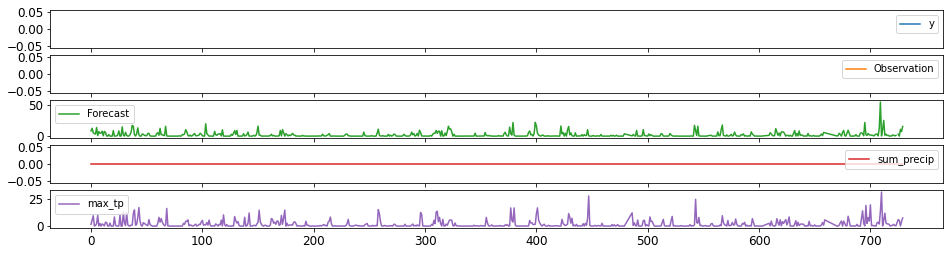

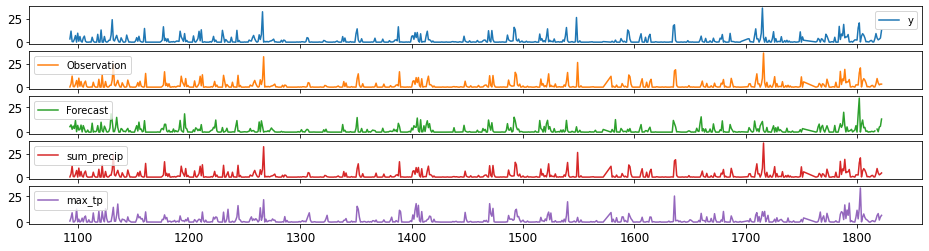

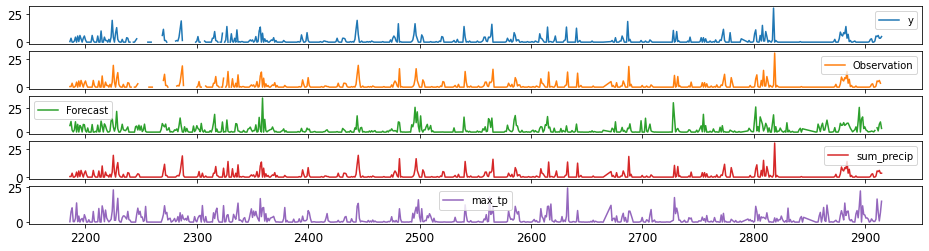

In [219]:
for i, (index, df_iter) in enumerate(df[~df.test].groupby('station')):
    df_iter[['y', 'Observation', 'Forecast', 'sum_precip', 'max_tp']].plot(subplots=True, fontsize=12, figsize=(16, 4))
    if i>=2:
        break

In [220]:
df[df.test]

,station,test,day,day_index,month,y,Observation,Forecast,mean_ws,std_ws,...,min_td,max_hu,min_hu,max_dd,min_dd,latitude,longitude,height,coef_saison,saison
730,14047002,True,215,0,2,NaN,0.606279,0.068060,3.909361,1.012741,...,273.594682,103.599024,70.728394,240.595084,187.812683,49.275,-0.712,60.0,0.666667,Winter
731,14047002,True,286,1,7,NaN,0.000025,0.005358,3.868034,0.891676,...,285.909769,102.515718,49.438747,335.387249,106.806240,49.275,-0.712,60.0,0.166667,Summer
732,14047002,True,254,2,5,NaN,12.126751,NaN,6.149567,2.302137,...,280.475278,99.638788,61.495394,234.410914,130.967718,49.275,-0.712,60.0,0.166667,Summer
733,14047002,True,265,3,5,NaN,0.078170,0.000065,2.169709,0.821677,...,284.703196,101.285982,63.836857,276.683464,226.143995,49.275,-0.712,60.0,0.166667,Summer
734,14047002,True,105,4,7,NaN,0.000000,0.000320,2.639666,1.006212,...,282.533596,103.075536,52.445057,363.165378,40.251069,49.275,-0.712,60.0,0.166667,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355220,95690001,True,326,358,9,NaN,3.000000,0.184848,4.816512,0.764589,...,283.540000,92.500000,72.500000,269.000000,193.000000,49.108,1.831,126.0,0.500000,Autumn
355221,95690001,True,124,359,8,NaN,0.000000,0.000000,2.240568,0.937018,...,287.210000,93.200000,60.700000,330.000000,16.000000,49.108,1.831,126.0,0.333333,Summer
355222,95690001,True,139,360,9,NaN,0.000000,5.266324,6.824416,1.316148,...,285.370000,94.000000,45.700000,230.000000,173.000000,49.108,1.831,126.0,0.500000,Autumn
355223,95690001,True,86,361,6,NaN,22.300000,0.000724,1.410754,0.732426,...,285.360000,97.000000,76.000000,347.000000,29.000000,49.108,1.831,126.0,0.000000,Summer


In [222]:
df.saison

0         Winter
1         Winter
2         Winter
3         Winter
4         Winter
           ...  
355220    Autumn
355221    Summer
355222    Autumn
355223    Summer
355224    Spring
Name: saison, Length: 347100, dtype: object

In [221]:
X_kaggle = df[df.test].copy()
X_kaggle["id"] = X_kaggle["station"].astype(str) + "_" + X_kaggle["day_index"].astype(str)
test_observation = pd.read_csv("Test/Baselines/Baseline_observation_test.csv").rename(columns = {"Id": "id"})[['id']] #For check Kaggle y prediction
X_kaggle = X_kaggle[X_kaggle.id.isin(test_observation.id)]

dict(X_kaggle.isna().mean())
#dict(X_kaggle[X_kaggle.max_dd.isna()].iloc[0])

{'station': 0.0,
 'test': 0.0,
 'day': 0.0,
 'day_index': 0.0,
 'month': 0.0,
 'y': 1.0,
 'Observation': 0.0,
 'Forecast': 0.06573878318064365,
 'mean_ws': 0.008339206013624619,
 'std_ws': 0.008339206013624619,
 'mean_p3031': 0.008339206013624619,
 'std_p3031': 0.008339206013624619,
 'mean_u10': 0.008339206013624619,
 'std_u10': 0.008339206013624619,
 'mean_v10': 0.008339206013624619,
 'std_v10': 0.008339206013624619,
 'mean_t2m': 0.008339206013624619,
 'std_t2m': 0.008339206013624619,
 'mean_d2m': 0.008339206013624619,
 'std_d2m': 0.008339206013624619,
 'mean_r': 0.008339206013624619,
 'std_r': 0.008339206013624619,
 'mean_msl': 0.008339206013624619,
 'std_msl': 0.008339206013624619,
 'mean_ff': 0.0,
 'std_ff': 0.0,
 'mean_t': 0.0,
 'std_t': 0.0,
 'mean_td': 0.0,
 'std_td': 0.0,
 'mean_hu': 0.0,
 'std_hu': 0.0,
 'mean_dd': 0.0,
 'std_dd': 0.0,
 'mean_precip': 0.0,
 'std_precip': 0.0,
 'sum_precip': 0.0,
 'max_tp': 0.0,
 'max_precip': 0.0,
 'max_ws': 0.008339206013624619,
 'min_ws': 0.